In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
'dataset',
shuffle = True,
image_size = (IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE )

Found 3242 files belonging to 4 classes.


In [10]:
class_names = dataset.class_names

In [11]:
class_names

['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

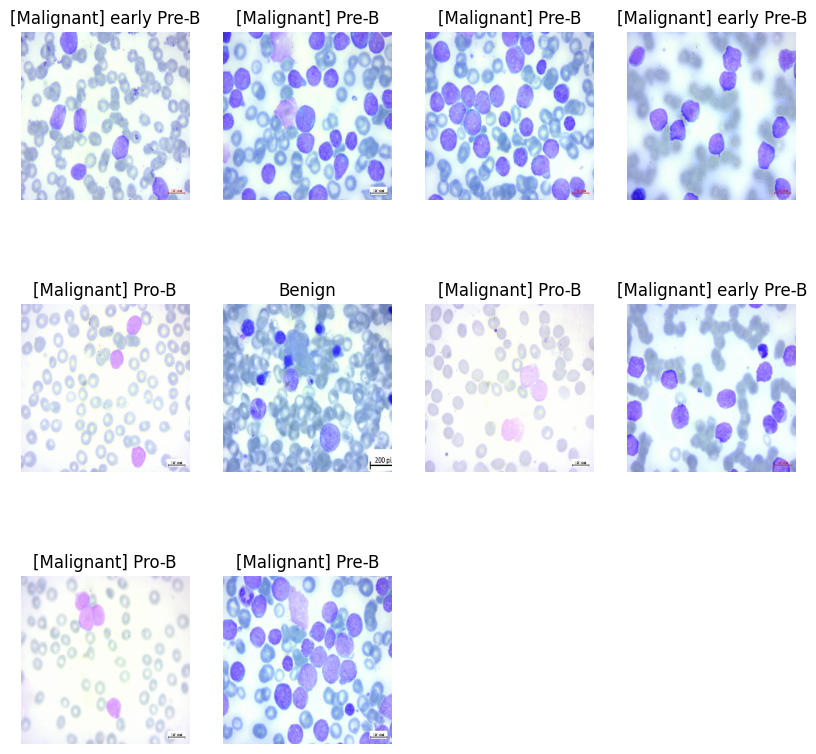

In [12]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch.shape)
    #print(label_batch.numpy)
    for i in range(10):
        ax = plt.subplot(3,4,i+1) # (dimension,dimension,index)
        plt.axis('off')
        plt.imshow(image_batch[i].numpy().astype(int))
        plt.title(class_names[label_batch[i]])

In [13]:
def get_dataset_partition_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1,shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds.shuffle(shuffle_size,seed = 12)
        
        
    train_ds = ds.take(int(train_split * ds_size)) #54
    val_ds = ds.skip(int(train_split * ds_size)) #skip 54 will take remaining 14
    # 0.1 % of 68 ~= 6
    test_ds = val_ds.skip(int(test_split * ds_size)) #This will take 8 inputs
    val_ds = val_ds.take(int(val_split * ds_size))
    return train_ds,test_ds,val_ds

In [14]:
train_ds,test_ds,val_ds = get_dataset_partition_tf(dataset) 

In [15]:
print("Training dataset : ",len(train_ds))
print("Test dataset: ",len(test_ds))
print("Validation dataset: ",len(val_ds))

Training dataset :  81
Test dataset:  11
Validation dataset:  10


In [16]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), # This is done ig for input..look it again
    layers.experimental.preprocessing.Rescaling(1.0/255) # this is for scaling rgb from 1-255 to 0-1
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), #Just flipping the images
    layers.experimental.preprocessing.RandomRotation(0.2) # this one is for rotating the images
])

In [18]:
n_classes = 4

model = tf.keras.Sequential([
    resize_and_rescale, # this part is still preprocessing
    data_augmentation, # and also this part
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding='same'), # convolution
    
    #for the above (kernel, dimension of the image, relu = rectifier function, input_data)
    
    layers.MaxPooling2D(2,2), # pooling, making 2d array to keep features and reduce size
    
    layers.Conv2D(32,(3,3),activation = 'relu',padding='same'),
    layers.MaxPooling2D(2,2), # second layer
    
    layers.Conv2D(64,(3,3),activation = 'relu',padding='same'),
    layers.MaxPooling2D(2,2), # third layer
    
    layers.Conv2D(64,(3,3),activation = 'relu',padding='same'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64,(3,3),activation = 'relu',padding='same'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64,(3,3),activation = 'relu',padding='same'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64,(3,3),activation = 'relu',padding='same'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation ='softmax'),
])

model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs = 50,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
81/81 [==============================] - 21s 253ms/step - loss: 0.6183 - accuracy: 0.7558 - val_loss: 0.4959 - val_accuracy: 0.7656
Epoch 2/50
81/81 [==============================] - 19s 236ms/step - loss: 0.4701 - accuracy: 0.8129 - val_loss: 0.4685 - val_accuracy: 0.7531
Epoch 3/50
81/81 [==============================] - 21s 259ms/step - loss: 0.3822 - accuracy: 0.8449 - val_loss: 0.2413 - val_accuracy: 0.9031
Epoch 4/50
81/81 [==============================] - 21s 255ms/step - loss: 0.2998 - accuracy: 0.8885 - val_loss: 0.5650 - val_accuracy: 0.7563
Epoch 5/50
81/81 [==============================] - 21s 260ms/step - loss: 0.3068 - accuracy: 0.8862 - val_loss: 0.3009 - val_accuracy: 0.8875
Epoch 6/50
81/81 [==============================] - 20s 244ms/step - loss: 0.2900 - accuracy: 0.8873 - val_loss: 0.2399 - val_accuracy: 0.9187
Epoch 7/50
81/81 [==============================] - 20s 244ms/step - loss: 0.2598 - accuracy: 0.8989 - val_loss: 0.2222 - val_accuracy: 0.9187

In [23]:
model.evaluate(test_ds)

11/11 [==============================] - 5s 69ms/step - loss: 0.3380 - accuracy: 0.9333


[0.3379999101161957, 0.9333333373069763]

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation for loss')

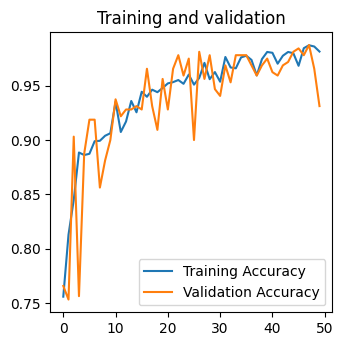

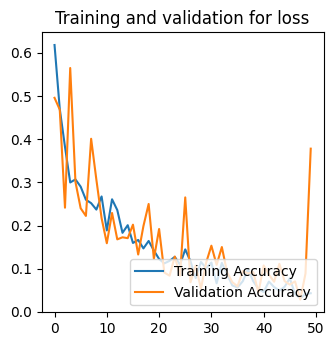

In [25]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(range(50),acc,label = 'Training Accuracy')
plt.plot(range(50),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation')

plt.figure(figsize=(8,8))
plt.subplot(2,2,2)
plt.plot(range(50),loss,label = 'Training Accuracy')
plt.plot(range(50),val_loss,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation for loss')

1/1 [==============================] - 0s 169ms/step
Predicted value:  [Malignant] Pre-B


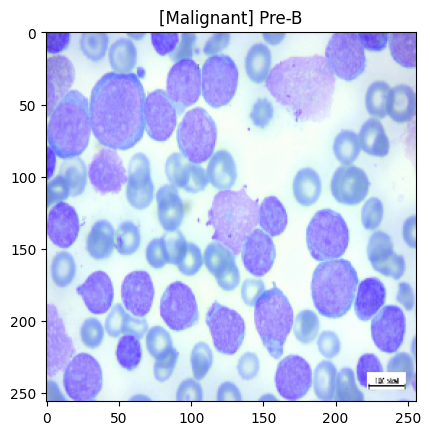

In [26]:
import numpy as np

for images_batch,label_batch in test_ds.take(1):
    img = images_batch[1].numpy().astype(int)
    name = class_names[label_batch[1].numpy()]
    
    plt.imshow(img)
    plt.title(name)
    batch_prediction = model.predict(images_batch)
    
    print("Predicted value: ",class_names[np.argmax(batch_prediction[1])])

In [27]:
model_version = 1
model.save(f"./saved_models/{model_version}")